In [41]:
import country_converter as coco
import geopandas as gpd
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt


In [42]:
# Merge the two dataframes
# ...following Ruben's notebook...
# merged_geo_df_complete = pd.merge(left = cl_real_happiness, right = geo_df)

merged_geo_df_complete = pd.read_csv("data/merged_geo_df_complete.csv", index_col=0)

#### Preparing Data for Mapping (Price/Sq Meter)

In [43]:
price_sq_meter = merged_geo_df_complete[['city','country', 'price_per_sq_meter (city)', 'country_code', 'geometry', 'iso2_code']]
avg_price_country = price_sq_meter.groupby(['country']).mean('price_per_sq_meter (city)')
avg_price_country.rename({"price_per_sq_meter (city)":"price_per_sq_meter"}, axis = 1, inplace=True) # It's averaged out to country now, across cities 
avg_price_country

,price_per_sq_meter
country,
Afghanistan,486.063333
Albania,887.849000
Algeria,947.055789
Andorra,4390.603333
Angola,5421.610000
...,...
Venezuela,665.510000
Vietnam,1748.847778
Yemen,2786.350000


In [44]:
country_geoms = price_sq_meter[['country', 'geometry']].drop_duplicates() # need drop_duplicates because psm had country repeated for each city 
country_geoms

,country,geometry
0,United States,MULTIPOLYGON (((-122.75301682799991 48.9925145...
2793,Hungary,POLYGON ((22.877600546000053 47.94673858700013...
2820,South Korea,MULTIPOLYGON (((128.36491946700005 38.62433502...
2834,China,MULTIPOLYGON (((78.91769413200012 33.386257833...
2894,India,MULTIPOLYGON (((77.80034631400014 35.495405579...
...,...,...
5000,Congo (Kinshasa),MULTIPOLYGON (((18.626387166000086 3.476868998...
5001,Myanmar,MULTIPOLYGON (((92.57587854000013 21.977574362...
5002,Comoros,MULTIPOLYGON (((43.78874759200005 -12.30803801...
5003,Lesotho,POLYGON ((28.980845581000068 -28.9090353389999...


In [45]:
avg_price_country_geoms = pd.merge(avg_price_country, country_geoms, how="inner", on="country") 

#### Mapping Price/Sq Meter

##### Things to fix before mapping:

Before mapping `avg_price_country_geoms` we need to ensure that its geometry column gets read properly as polygons and not merely as strings (which is how it's being stored now). Otherwise it will cause an error later when we attempt to convert it to a geopandas dataframe before plotting.

In [46]:
avg_price_country_geoms['geometry'] = gpd.GeoSeries.from_wkt(avg_price_country_geoms['geometry']) 

Other issues:
* Numerous African countries aren't being plotted


In [47]:
avg_price_country_geoms.price_per_sq_meter.fillna(0, inplace=True)

* Certain countries have erroneous data which skews the display (Niger, Somalia, and Burundi in particular)

In [48]:
print(avg_price_country_geoms[['country', 'price_per_sq_meter']].sort_values("price_per_sq_meter", ascending=False).head(20))

def fixPrice(row):
  # Gabon Zambia Malawi Papua New Guinea Senegal 
  extreme_outliers = ["Singapore","Niger", "Solomon Islands", "Somalia", "Burundi", "Monaco", 'Gabon', 'Zambia', 'Malawi', 'Papua New Guinea', 'Senegal']
  if row.country in extreme_outliers: # Monaco could actually be accurate but renders visualization unusable
    row.price_per_sq_meter = 0
  return row

avg_price_country_geoms[['country', 'price_per_sq_meter']] = avg_price_country_geoms[['country', 'price_per_sq_meter']].apply(fixPrice, axis=1)

              country  price_per_sq_meter
123             Niger       240963.670000
152   Solomon Islands        85048.560000
111            Monaco        82192.130000
153           Somalia        67728.600000
27            Burundi        24307.240000
148         Singapore        20752.740000
59              Gabon        13654.610000
162       Switzerland        12781.841667
184            Zambia        10763.910000
102            Malawi        10507.210000
18            Bermuda        10381.960000
100        Luxembourg         9742.326667
131  Papua New Guinea         9246.090000
145           Senegal         9016.380000
58   French Polynesia         8830.390000
85             Jersey         8408.280000
64          Gibraltar         8161.050000
84              Japan         8040.846800
155       South Korea         7623.001429
80             Israel         7104.060968


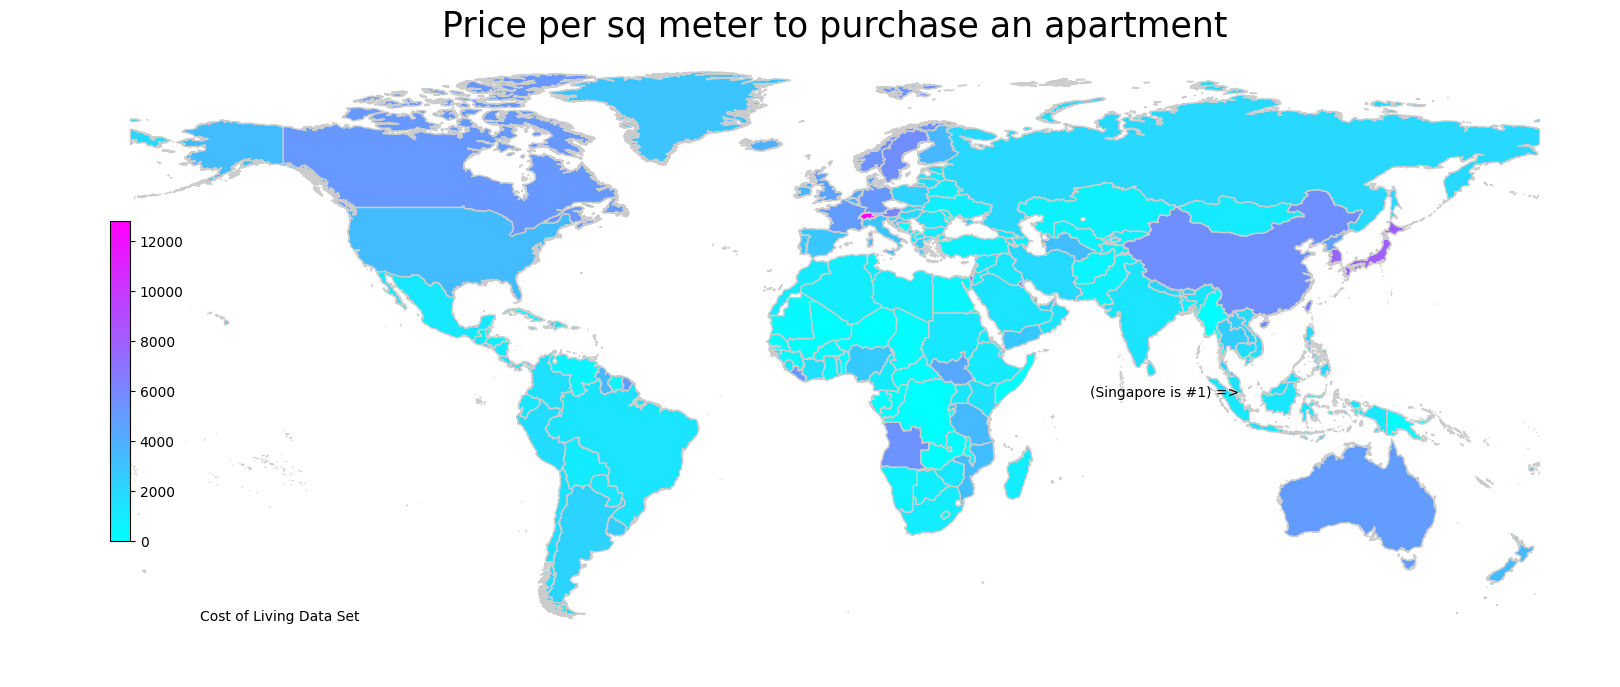

In [49]:
from geopandas import GeoDataFrame

df = gpd.GeoDataFrame(avg_price_country_geoms, geometry='geometry') 

title = 'Price per sq meter to purchase an apartment'
source = 'Cost of Living Data Set'
col = 'price_per_sq_meter'

# source = 'Source: relataly.com \nGrowth Rate = New cases / All previous cases'
vmin = df[col].min()
vmax = df[col].max()
cmap = 'cool'

# Create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(20, 8))

# Remove the axis
ax.axis('off')
df.plot(column=col, ax=ax, edgecolor='0.8', linewidth=1, cmap=cmap)

# Add a title
ax.set_title(title, fontdict={'fontsize': '25', 'fontweight': '3'})

# Create an annotation for the data source
ax.annotate(source, xy=(0.1, .08), xycoords='figure fraction', horizontalalignment='left', verticalalignment='bottom', fontsize=10)
ax.annotate("(Singapore is #1) =>", xy=(.545, .36), xycoords='figure fraction', horizontalalignment='left', verticalalignment='bottom', fontsize=10)



# Create colorbar as a legend
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)

# Empty array for the data range
sm._A = []

# Add the colorbar to the figure
cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
cbar = fig.colorbar(sm, cax=cbaxes)

### Work for Code Review (Friday December 9th)

Let's replace the geometry for the United States in our geodataframe with geometries for all the states. We accessed such a shapefile in our other notebook `alex_work.ipynb`

In [81]:
import geopandas as gpd

url = (
    "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data"
)
state_geo = f"{url}/us-states.json"

state_geo_df = gpd.read_file(state_geo)
state_geo_df.rename({"name":"state"}, axis=1, inplace = True)
state_data = pd.read_csv("data/state_data.csv", index_col = 0)
state_data_geo = pd.merge(state_geo_df, state_data, how = "inner", on="state")
state_data_geo.drop("id", inplace=True, axis=1)


In [82]:
state_data_geo.head()

,state,geometry,price_per_sq_meter
0,Alabama,"POLYGON ((-87.35930 35.00118, -85.60667 34.984...",2489.468693
1,Alaska,"MULTIPOLYGON (((-131.60202 55.11798, -131.5691...",1950.977500
2,Arizona,"POLYGON ((-109.04250 37.00026, -109.04798 31.3...",3543.061289
3,Arkansas,"POLYGON ((-94.47384 36.50186, -90.15254 36.496...",1935.446037
4,California,"POLYGON ((-123.23326 42.00619, -122.37885 42.0...",5003.259356


In [98]:
# Need to rename "state_data_geo.state" and "avg_price_country_geoms.country" to match before we join 
state_data_geo.rename({"state":"region"}, axis=1, inplace=True)
avg_price_country_geoms.rename({"country":"region"}, axis=1, inplace=True)
# Drop US from avg_price_country_geoms to replace with the states
# avg_price_country_geoms.region.drop(178, axis=0, inplace=True) # -- why doesn't this work to change avg_price_country_geoms?
avg_price_country_geoms = avg_price_country_geoms[avg_price_country_geoms.region != "United States"]

region_geoms = pd.merge(state_data_geo, avg_price_country_geoms, how="outer")

,region,geometry,price_per_sq_meter
0,Alabama,"POLYGON ((-87.35930 35.00118, -85.60667 34.984...",2489.468693
1,Alaska,"MULTIPOLYGON (((-131.60202 55.11798, -131.5691...",1950.977500
2,Arizona,"POLYGON ((-109.04250 37.00026, -109.04798 31.3...",3543.061289
3,Arkansas,"POLYGON ((-94.47384 36.50186, -90.15254 36.496...",1935.446037
4,California,"POLYGON ((-123.23326 42.00619, -122.37885 42.0...",5003.259356
...,...,...,...
230,Venezuela,"MULTIPOLYGON (((-60.02099 8.55801, -59.95969 8...",665.510000
231,Vietnam,"MULTIPOLYGON (((107.52039 14.70458, 107.52225 ...",1748.847778
232,Yemen,"MULTIPOLYGON (((51.97861 18.99564, 51.98569 18...",2786.350000
233,Zambia,"POLYGON ((32.92086 -9.40790, 32.92303 -9.46629...",0.000000
